In [1]:
import numpy as np
import torch
import torch.nn as nn
import lightning.pytorch as pl
import torchmetrics
import torchvision
from torchinfo import summary
from torchview import draw_graph
from IPython.display import display

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly.offline as py
import plotly.graph_objs as go

from sklearn.preprocessing import MinMaxScaler


In [2]:
# Config & Setup Details
cfg_batch_size  = 50
cfg_max_epochs  = 10
cfg_num_workers = 2

# Learning Config
cfg_split   = 0.8
cfg_seq_len = 180

# Data Config
cfg_data_separator = ","
cfg_data_date_fmt  = "%Y-%m-%d"
cfg_data_url_train = "https://s3.amazonaws.com/mtsu.csci.7850.project/train.csv"

# Logger Config
cfg_logger_dir     = "logs"
cfg_logger_name    = "Project"
cfg_logger_version = "transformer"


In [3]:
# Setup CPU or GPU Device Settings for CUDA
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    print(torch.cuda.get_device_properties("cuda"))
    print("Number of devices:",torch.cuda.device_count())
    device = ("cuda")
else:
    print("Only CPU is available...")
    device = ("cpu")

Only CPU is available...


In [5]:
# Load Data - Parse the Date Column
df_raw = pd.read_csv(cfg_data_url_train, parse_dates=["date"])

print(f"Raw Shape: {df_raw.shape}")
print(df_raw.head())
print("\n********\n")

# Format Date Column to DateTime
df_raw['date'] = pd.to_datetime(df_raw['date'], format=cfg_data_date_fmt)

# Get Sales (Sum across all Stores) Grouped by Date
df_grouped_date = df_raw.groupby(['date'])['sales'].sum().reset_index()
print(f"Grouped by Date Shape: {df_grouped_date.shape}")
print(df_grouped_date)
print("\n********\n")

# Extract Only Sales data
df_sales_data = df_grouped_date['sales']

# Show the New Table
print(f"Training Shape: {df_sales_data.shape}")
print(df_sales_data)
print("\n********\n")



Raw Shape: (913000, 4)
        date  store  item  sales
0 2013-01-01      1     1     13
1 2013-01-02      1     1     11
2 2013-01-03      1     1     14
3 2013-01-04      1     1     13
4 2013-01-05      1     1     10

********

Grouped by Date Shape: (1826, 2)
           date  sales
0    2013-01-01  13696
1    2013-01-02  13678
2    2013-01-03  14488
3    2013-01-04  15677
4    2013-01-05  16237
...         ...    ...
1821 2017-12-27  20378
1822 2017-12-28  21885
1823 2017-12-29  23535
1824 2017-12-30  24988
1825 2017-12-31  26420

[1826 rows x 2 columns]

********

Training Shape: (1826,)
0       13696
1       13678
2       14488
3       15677
4       16237
        ...  
1821    20378
1822    21885
1823    23535
1824    24988
1825    26420
Name: sales, Length: 1826, dtype: int64

********



In [6]:
# Assuming 'sales_data' is your array of sales values
scaler = MinMaxScaler(feature_range=(-1, 1))
sales_normalized = scaler.fit_transform(np.array(df_sales_data).reshape(-1, 1))

In [7]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

# Choose a sequence length (window size)
seq_length = cfg_seq_len  # for example, 180 days
data_sequences = create_inout_sequences(torch.FloatTensor(sales_normalized), seq_length)

test = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13])
test_seq = create_inout_sequences(torch.FloatTensor(test), 5)

test_seq


[(tensor([1., 2., 3., 4., 5.]), tensor([6.])),
 (tensor([2., 3., 4., 5., 6.]), tensor([7.])),
 (tensor([3., 4., 5., 6., 7.]), tensor([8.])),
 (tensor([4., 5., 6., 7., 8.]), tensor([9.])),
 (tensor([5., 6., 7., 8., 9.]), tensor([10.])),
 (tensor([ 6.,  7.,  8.,  9., 10.]), tensor([11.])),
 (tensor([ 7.,  8.,  9., 10., 11.]), tensor([12.])),
 (tensor([ 8.,  9., 10., 11., 12.]), tensor([13.]))]

In [53]:
import torch.nn as nn
import math

class Transformer(nn.Module):
    def __init__(self, n_features, n_heads, n_hidden, n_layers, dropout):
        super(Transformer, self).__init__()
        self.model_type = 'Transformer'
        self.src_mask = None
        self.pos_encoder = PositionalEncoding(n_features, dropout)
        encoder_layers = nn.TransformerEncoderLayer(n_features, n_heads, n_hidden, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, n_layers)
        self.encoder = nn.Linear(1, n_features)
        self.n_features = n_features
        self.decoder = nn.Linear(n_features, 1)
        
    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
        return mask

    def predict(self, x):
        return self(x)
        
    def forward(self, src):
        if self.src_mask is None or self.src_mask.size(0) != len(src):
            device = src.device
            mask = self._generate_square_subsequent_mask(len(src)).to(device)
            self.src_mask = mask

        src = self.encoder(src).unsqueeze(1)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, self.src_mask)
        output = self.decoder(output.squeeze(1))
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

# Define Trainable Module
class TransformerModel(pl.LightningModule):
    def __init__(self, module, **kwargs):
        # This is the contructor, where we typically make
        # layer objects using provided arguments. 
        super().__init__(**kwargs) # Call the super class constructor 
        self.module = module
        self.loss = nn.MSELoss()
    
    def forward(self, x):
        return self.module.forward(x) 
        
    def predict(self, x):
        return self.module.predict(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001, weight_decay=1e-4)
        return optimizer

    def training_step(self, train_batch, batch_idx):
        x = train_batch[0]
        y_true = train_batch[1]
        #x, y_true = train_batch
        y_pred = self(x)
        loss = self.loss(y_pred, y_true)
        self.log('train_loss', loss, on_step=False, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x = val_batch[0]
        y_true = val_batch[1]
        y_pred = self(x)
        print(y_pred)
        loss = self.loss(y_pred, y_true)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss

# Parameters for the model
n_features = 512  # embedding dimension
n_heads = 8  # number of heads in multi-head attention
n_hidden = 2048  # hidden layer size
n_layers = 3  # number of transformer layers
dropout = 0.1  # dropout rate

model = TransformerModel(Transformer(n_features, n_heads, n_hidden, n_layers, dropout))


In [54]:
summary(model, input_data=torch.Tensor(sales_normalized[0:5]).float())

Layer (type:depth-idx)                             Output Shape              Param #
TransformerModel                                   [5, 1]                    --
├─Transformer: 1-1                                 --                        --
│    └─Linear: 2-1                                 [5, 512]                  1,024
│    └─PositionalEncoding: 2-2                     [5, 1, 512]               --
│    │    └─Dropout: 3-1                           [5, 1, 512]               --
│    └─TransformerEncoder: 2-3                     [5, 1, 512]               --
│    │    └─ModuleList: 3-2                        --                        9,457,152
│    └─Linear: 2-4                                 [5, 1]                    513
Total params: 9,458,689
Trainable params: 9,458,689
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 31.53
Input size (MB): 0.00
Forward/backward pass size (MB): 0.45
Params size (MB): 25.23
Estimated Total Size (MB): 25.68

In [52]:
model.predict(torch.Tensor(sales_normalized[1:2]).float())

tensor([[0.4282]], grad_fn=<AddmmBackward0>)

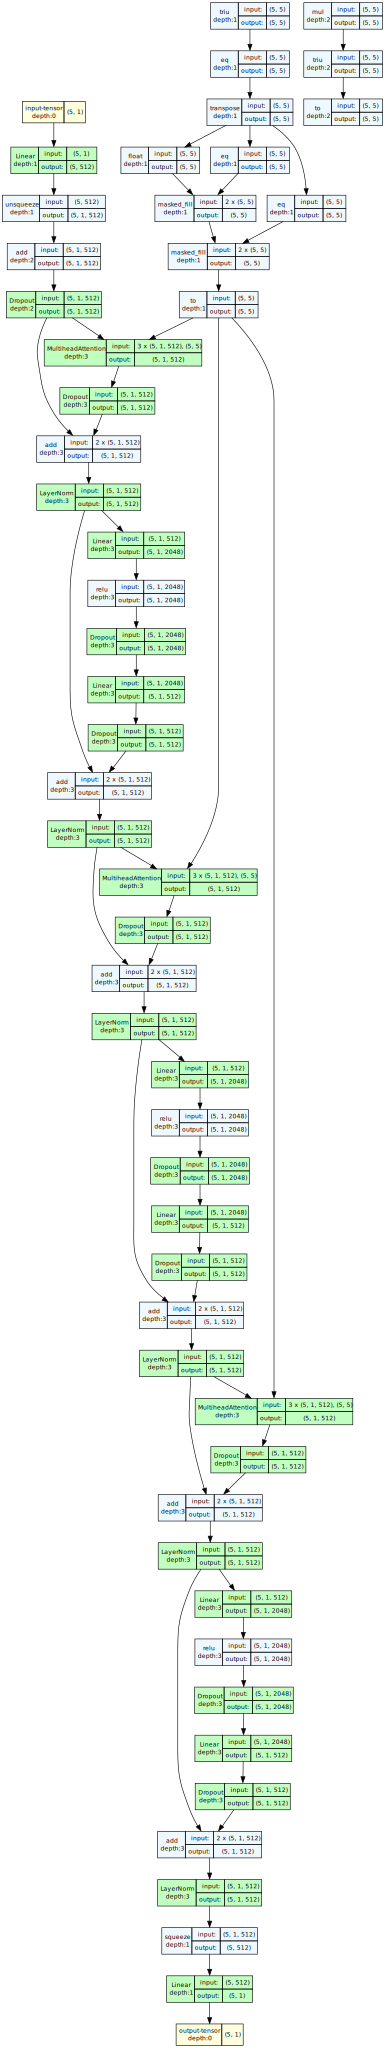

In [43]:
model_graph = draw_graph(model,
                         input_data=torch.Tensor(sales_normalized[0:5]).float(),
                         device=device,
                         hide_inner_tensors=True,
                         hide_module_functions=True,
                         expand_nested=False,
                         depth=3,
                         dtypes=[torch.long])

model_graph.visual_graph

In [55]:
# Split the data into training and testing sets
train_size = int(cfg_split * len(data_sequences))

sales_train = data_sequences[:train_size]
sales_val = data_sequences[train_size:]

#print(f"Training Shape: {sales_train.shape}")
#print(f"Val Shape:      {sales_val.shape}")

In [66]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[0][idx], self.data[1][idx]


train_dataset = CustomDataset(sales_train)
val_dataset = CustomDataset(sales_val)

In [67]:
val_dataset

In [68]:
xy_train = torch.utils.data.DataLoader(train_dataset, 
                                       shuffle=True, 
                                       batch_size=cfg_batch_size, 
                                       num_workers=cfg_num_workers)

xy_val = torch.utils.data.DataLoader(val_dataset,  
                                     shuffle=False, 
                                     batch_size=cfg_batch_size, 
                                     num_workers=cfg_num_workers)

In [69]:
logger = pl.loggers.CSVLogger("lightning_logs", 
                              name="Project",
                              version="1.0.0")

In [70]:
trainer = pl.Trainer(logger=logger, 
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     enable_checkpointing=False, 
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=50)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [71]:
trainer.validate(model, xy_val)

Validation: 0it [00:00, ?it/s]

IndexError: Caught IndexError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
           ^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/conda/lib/python3.11/site-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_820/2932050509.py", line 11, in __getitem__
    return self.data[0][idx], self.data[1][idx]
           ~~~~~~~~~~~~^^^^^
IndexError: tuple index out of range
